In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
import pickle
import requests
import numpy as np
from trueskill import TrueSkill, rate_1vs1
from scipy.stats import norm
from collections import defaultdict
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["figure.titlesize"] = 20

## Load data

In [3]:
df = pd.read_csv('data_preprocessed.csv', parse_dates=['Date'])

In [4]:
# get a dictionary lookup with team id and the day before the team first played. this is the day that we will set the initial rating on

teams = pd.melt(df[['winner', 'loser', 'Date']], value_vars=['winner', 'loser'], id_vars='Date', value_name='team', var_name='status')
all_teams = teams.team.unique()

## Brier score

In [5]:
def brier_score(preds: list, outs: list) -> float:
    return np.average((outs - preds) ** 2)

## Trueskill

If some player’s rating is β higher than another player’s, the player may have about a 76% (specifically $\Phi(\frac{1}{\sqrt{2}})$ chance to beat the other player. The default value of β is 25/6.

$\Phi$ is the normal CDF

In [16]:
# draw probability: can be selected individually for each matchup from previous history
# we set it here once for the entire history
def rate_trueskill(p_draw, mu=25, sigma=8.333, beta=8.333/2, tau=8.333):
    ts = TrueSkill(backend='scipy', mu=mu, sigma=sigma, beta=beta, tau=tau)
    # set up rating lookup
    ratings = dict()
    for t in all_teams:
        ratings[t] = {'date': [], 'rating': []}
    for row in df.itertuples():
        # use default rating if team shows up for the first time
        try:
            old_rating_winner = ratings[row.winner]['rating'][-1]
        except IndexError:
            old_rating_winner = ts.Rating(mu=mu, sigma=sigma)
        try:
            old_rating_loser = ratings[row.loser]['rating'][-1]
        except IndexError:
            old_rating_loser = ts.Rating(mu=mu, sigma=sigma)
        
        # algorithm magic
        winner_new, loser_new = rate_1vs1(old_rating_winner, old_rating_loser, drawn=row.draw)
        ratings[row.winner]['date'].append(row.Date)
        ratings[row.loser]['date'].append(row.Date)
        ratings[row.winner]['rating'].append(winner_new)
        ratings[row.loser]['rating'].append(loser_new)
    return ratings

In [17]:
ratings = rate_trueskill(p_draw=df.draw.mean())

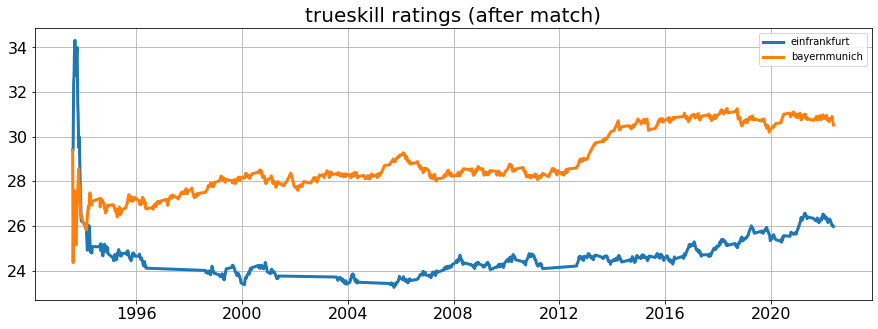

In [18]:
# plotting time: let's look at some teams over time!
team1 = 'einfrankfurt'
team2 = 'bayernmunich'
fig, ax = plt.subplots()
plt.plot(ratings[team1]['date'], [i.mu for i in ratings[team1]['rating']], label=team1)
plt.plot(ratings[team2]['date'], [i.mu for i in ratings[team2]['rating']], label=team2)
plt.legend()
_ = plt.title('trueskill ratings (after match)')

In [11]:
ts = TrueSkill()

In [19]:
from trueskill import rate_1vs1, rate

In [21]:
TrueSkill.rate?

Signature:
TrueSkill.rate(
    self,
    rating_groups,
    ranks=None,
    weights=None,
    min_delta=0.0001,
)
Docstring:
Recalculates ratings by the ranking table::

   env = TrueSkill()  # uses default settings
   # create ratings
   r1 = env.create_rating(42.222)
   r2 = env.create_rating(89.999)
   # calculate new ratings
   rating_groups = [(r1,), (r2,)]
   rated_rating_groups = env.rate(rating_groups, ranks=[0, 1])
   # save new ratings
   (r1,), (r2,) = rated_rating_groups

``rating_groups`` is a list of rating tuples or dictionaries that
represents each team of the match.  You will get a result as same
structure as this argument.  Rating dictionaries for this may be useful
to choose specific player's new rating::

   # load players from the database
   p1 = load_player_from_database('Arpad Emrick Elo')
   p2 = load_player_from_database('Mark Glickman')
   p3 = load_player_from_database('Heungsub Lee')
   # calculate new ratings
   rating_groups = [{p1: p1.rating, p2: p2.rati

In [ ]:
# plot season and day wide glicko
team = 'bayernmunich'
plt.figure()

#plt.plot(match_dates[team], elo_30_ratings[team][:-1], label='elo 32')
plt.errorbar(ratings[team]['date'], [i.mu for i in ratings[team]['rating']], yerr=[i.sigma for i in ratings[team]['rating']], errorevery=1, ecolor='b', color='r')

_ = plt.title(team + ' ratings with confidence intervals')

## Make predictions

In [ ]:
# win predictions
# TrueSkill provides a function (quality()) to calculate a draw probability between arbitrary ratings (because matchmaking is the goal)
# But there’s no function for a win probability.

def ts_win_probability(r1, r2, p_draw):
    delta_mu = r1.mu - r2.mu
    sigmas = np.array([r1.sigma, r2.sigma, np.sqrt(2)*8.333/2])
    p_1 = norm.cdf(delta_mu / np.linalg.norm(sigmas))
    p_2 = 1 - p_1
    # correct for draws
    p_1 -= 0.5 * p_draw
    p_2 -= 0.5 * p_draw
    if p_1 < 0:
        p_1 = 0
        p_2 += np.abs(p_1)
    if p_2 < 0:
        p2 = 0
        p_1 += np.abs(p_2)

    return p_1, p_2, p_draw

In [ ]:
def get_rating_on_date(rating_dict, team, date, mu=25, sigma=8.333):
    # todo: how do we manage ratings during calibration period?
    # since we stored the ratings AFTER the match, we always need to use the one before that day
    date_idx = rating_dict[team]['date'].index(date)
    if date_idx >= 1:
        return rating_dict[team]['rating'][date_idx - 1]
    else:
        return ts.Rating(mu=mu, sigma=sigma)

In [ ]:
ts_predictions = []
for winner, loser, date in zip(df.winner.values, df.loser.values, df.Date.values):
    winner_rating = get_rating_on_date(ratings, winner, date)
    loser_rating = get_rating_on_date(ratings, loser, date)
    ts_predictions.append(ts_win_probability(winner_rating, loser_rating, p_draw)[0])

In [ ]:
brier_score(ts_predictions, np.ones(len(ts_predictions))-0.5*df.draw)